# Соревнование ML 2025 Spring. Porn Detection

## Контакты участника

Если у вас возникли вопросы по этому проекту или вы хотите обсудить сотрудничество, свяжитесь со мной:

- Email: gerceg0808@yandex.ru   
- Tg: [@GercKLIM](https://t.me/GercKLIM)
- GitHub: [@GercKLIM](https://github.com/GercKLIM) 



## Описание
Участникам предоставлен набор данных, содержащий url и title веб-страниц, а также метку класса - 1, если страница относится к порнографии и 0 - не порнография.

Задача состоит в том, чтобы на основе предоставленного набора тренировочных данных построить бинарный классификатор веб-страниц.
## Метрика качества
Метрика качества в данном соревновании: **F1-Score**.

Разбиение тестового набора на Public-/Private- части выполнено в пропорции 30/70%.

Файл ответов должен содержать заголовок и иметь следующий вид:

```plaintext
ID,label
135309,0
135310,0
135311,0
135312,1
...



## 1. Импорт библиотек и подготовка к работе

In [61]:
# Для импорта датасетов 
import pandas as pd 

# Для вывода графиков истории обучения
import matplotlib.pyplot as plt

# Для создания модели
import tensorflow as tf 
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential

# Для метрик
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score


In [62]:
# Вывод версий библиотек 
print(f"Версия TensorFlow: {tf.__version__}")
print(f"Версия pandas: {pd.__version__}")

Версия TensorFlow: 2.18.0
Версия pandas: 2.2.3


In [63]:
# Получаем информацию о количестве доступных вычислительных блоков
print(f"Доступные GPU: {tf.config.list_physical_devices('GPU')}")
print(f"Доступные CPU: {tf.config.list_physical_devices('CPU')}")


Доступные GPU: []
Доступные CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [64]:
# Проверяем поддержку CUDA
if (tf.test.is_built_with_cuda()):
    print("TensorFlow построен с поддержкой CUDA")
else:
    print("TensorFlow НЕ построен с поддержкой CUDA")
    

TensorFlow НЕ построен с поддержкой CUDA


## 2. Загрузка тренирочной выборки

Для начала определим путь к файлу тренировочного датасета и загрузим его с помощью библиотеки `pandas`. 

После загрузки выполним предобработку данных, заменив пропущенные значения (`NaN`) на пустые строки.

In [65]:
# Путь к файлу тренировочного датасета
train_ds_path = 'datasets/train.csv'

# Получение треничровочго датасета
train_ds = pd.read_csv(train_ds_path, encoding='utf-8')

# Замена NaN на пустые строки
train_ds = train_ds.fillna('')


## 3. Обработка выборки

Предобработка текстовых данных с использованием слоев векторизации из библиотеки TensorFlow. Каждый текстовый признак (`url` и `title`) преобразуется в последовательность целых чисел фиксированной длины.

### Параметры векторизации
- `max_tokens`: Максимальное количество уникальных слов в словаре.
- `output_sequence_length`: Длина выходной последовательности после векторизации.


In [66]:
# Максимальное количество уникальных слов
max_tokens = 20000      

# Длина последовательности после векторизации
output_sequence_length = 50


### Создание слоев векторизации
Для каждого текстового признака (`url` и `title`) создается отдельный слой векторизации:
- Слои настраиваются на параметры `max_tokens`, `output_mode='int'`  и `output_sequence_length`.
- Метод `.adapt()` используется для обучения векторизаторов на основе данных из соответствующих столбцов тренировочного датасета (`train_ds['url']` и `train_ds['title']`).


In [67]:
# Создаем слой векторизации для url
url_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)

# Создаем слой векторизации для title
title_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)


In [68]:
# Адаптируем векторизаторы на данных
url_vectorizer.adapt(train_ds['url'])
title_vectorizer.adapt(train_ds['title'])


### Преобразование данных
Функция `preprocess_data` объединяет векторизованные представления `url` и `title` в одну последовательность:
- Для каждого текстового признака вызывается соответствующий векторизатор.
- Результаты конкатенируются по первой оси с помощью функции `tf.concat`.

После получаем:
- `X_train`: Входные данные, полученные путем применения функции `preprocess_data` к столбцам `url` и `title`.
- `y_train`: Целевые метки, взятые из столбца `label` тренировочного датасета.



In [69]:
# Функция для преобразования данных
def preprocess_data(url, title):
    url_vec = url_vectorizer(url)
    title_vec = title_vectorizer(title)
    return tf.concat([url_vec, title_vec], axis=1)


In [70]:
# Применяем препроцессинг к данным
X_train = preprocess_data(train_ds['url'], train_ds['title'])
y_train = train_ds['label']

## 4. Создание модели

Возьмем архитектуру нейронной сети **Bag of Embeddings with Mean Pooling**, предназначенной для решения задачи текстовой бинарной классификации. 

### Параметры модели
- `embedding_dim`: Размерность эмбеддингов .
- `num_classes`: Количество выходных классов.



In [71]:
# Параметры модели
embedding_dim = 16  # Размерность эмбеддингов
num_classes = 1  # Бинарная классификация


### Архитектура модели
Модель состоит из следующих слоев:
1. **Embedding**: Преобразует индексы слов в плотные векторы фиксированной размерности.
   - `input_dim`: Размер словаря плюс один (`max_tokens + 1`).
   - `output_dim`: Размерность эмбеддингов (`embedding_dim`).
   - `input_length`: Длина входной последовательности после конкатенации (`output_sequence_length * 2`).
2. **GlobalAveragePooling1D**: Выполняет усреднение по всем токенам в последовательности, что снижает размерность данных и предотвращает переобучение.
3. **Dense (32 нейронов)**: Полносвязный слой с функцией активации ReLU для нелинейного преобразования данных.
4. **Dense (1 нейрон)**: Выходной полносвязный слой с сигмоидной функцией активации для бинарной классификации.



In [72]:
# Создаем модель
model = Sequential([
    Embedding(input_dim=max_tokens + 1, output_dim=embedding_dim), 
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

### Компиляция модели
При компиляции модели используются следующие параметры:
- Оптимизатор: `adam` (адаптивный оптимизатор)
- Функция потерь: `binary_crossentropy` (бинарная кросс-энтропия).
- Метрики: `accuracy` (точность классификации).

In [73]:
# Компилируем модель
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Бинарная кросс-энтропия для бинарной классификации
    metrics=['accuracy']
)

## 5. Обучение модели

Обучение нейронной сети на подготовленных данных.

### Параметры обучения
- `X_train`: Входные данные для обучения, полученные на предыдущем этапе предобработки.
- `y_train`: Целевые метки для обучения, соответствующие входным данным.
- `epochs`: Количество эпох обучения (установлено значение 5).
- `batch_size`: Размер пакета данных для одного шага обучения (установлено значение 32).
- `validation_split`: Часть тренировочных данных, которая будет использоваться для валидации модели (10% от всего тренировочного набора).

Метод `model.fit()` используется для запуска процесса обучения. На каждой эпохе модель обучается на обучающих данных и оценивает свою производительность на валидационном наборе данных. Результаты обучения (потеря и точность) сохраняются в переменной `history` для дальнейшего анализа.

После завершения обучения модель сохраняется в файл с помощью метода `model.save()`. Файл сохраняется в формате Keras (`.keras`)

In [74]:
# Обучение модели
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.05  
)

model.save("model_test.keras")


Epoch 1/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8904 - loss: 0.3182 - val_accuracy: 0.9678 - val_loss: 0.1006
Epoch 2/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9716 - loss: 0.0867 - val_accuracy: 0.9821 - val_loss: 0.0677
Epoch 3/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9816 - loss: 0.0563 - val_accuracy: 0.9846 - val_loss: 0.0533
Epoch 4/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9842 - loss: 0.0463 - val_accuracy: 0.9858 - val_loss: 0.0435
Epoch 5/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9864 - loss: 0.0404 - val_accuracy: 0.9830 - val_loss: 0.0560
Epoch 6/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9881 - loss: 0.0365 - val_accuracy: 0.9888 - val_loss: 0.0384
Epoch 7/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9878 - loss: 0.0357 - val_accuracy: 0.9840 - val_loss: 0.0490
Epoch 8/10
4017/4017 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9893 - loss: 0

## 6. Выводим результаты обучения

Выведем анализ результатов обучения модели: оценку производительности на тренировочной выборке и визуализацию процесса обучения.


### Оценка модели на тренировочной выборке

Метод `model.evaluate()` используется для оценки потерь и точности модели на тренировочных данных:
- Переменная `train_loss` хранит значение функции потерь на тренировочной выборке.
- Переменная `train_accuracy` хранит значение точности классификации на тренировочной выборке.
- Результаты выводятся с помощью функции `print()` с форматированием до четырех знаков после запятой.


In [75]:
# Оценка модели на тренировочной выборке
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=2)
print(f"Потери на тренировочной выборке: {train_loss:.4f}")
print(f"Точность на тренировочной выборке: {train_accuracy:.4f}")

4229/4229 - 6s - 1ms/step - accuracy: 0.9931 - loss: 0.0212
Потери на тренировочной выборке: 0.0212
Точность на тренировочной выборке: 0.9931


### Визуализация истории обучения

История обучения (`history`) содержит данные о потере и точности на каждой эпохе. Эти данные извлекаются в следующие переменные:
- `train_loss`: Значения функции потерь на тренировочных данных.
- `val_loss`: Значения функции потерь на валидационных данных.
- `train_accuracy`: Значения точности на тренировочных данных.
- `val_accuracy`: Значения точности на валидационных данных.


In [76]:
# Извлекаем данные из history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Для визуализации процесса обучения используем Matplotlib:
1. **График потерь**:
   - Отображаются значения функции потерь на тренировочных (`train_loss`) и валидационных (`val_loss`) данных.
   - График строится по эпохам (`epochs`), где каждая эпоха соответствует одному значению потери.
2. **График точности**:
   - Отображаются значения точности на тренировочных (`train_accuracy`) и валидационных (`val_accuracy`) данных.
   - График также строится по эпохам (`epochs`).

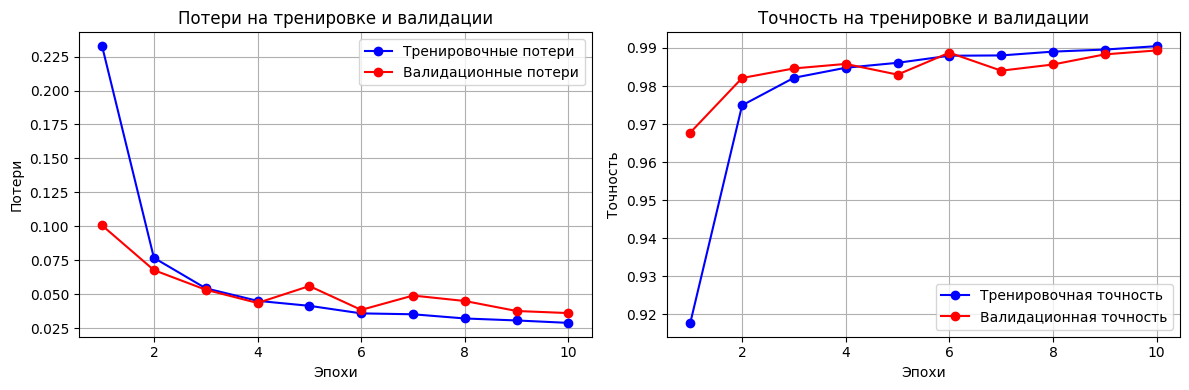

In [77]:
# Определяем количество эпох
epochs = range(1, len(train_loss) + 1)
# Создаем график для потерь
plt.figure(figsize=(12, 4))
# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Тренировочные потери')
plt.plot(epochs, val_loss, 'ro-', label='Валидационные потери')
plt.title('Потери на тренировке и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Тренировочная точность')
plt.plot(epochs, val_accuracy, 'ro-', label='Валидационная точность')
plt.title('Точность на тренировке и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# Показываем графики
plt.tight_layout()
plt.show()

## Метрика на тренировочной выборке

Вычислим метрики качества для оценки производительности модели на тренировочных данных. Используются метрики **Precision (точность)**, **Recall (полнота)** и **F1-Score**.

### Предсказание вероятностей и преобразование в метки
1. **Предсказание вероятностей**: 
   - Метод `model.predict()` используется для получения предсказанных вероятностей классов (`y_pred_proba`) на основе входных данных (`X_train`).
   - Размер батча (`batch_size=32`) и параметр `verbose=1` обеспечивают отображение прогресса предсказания.
   
2. **Преобразование вероятностей в метки**:
   - Вероятности преобразуются в бинарные метки (`0` или `1`) с помощью порогового значения `0.5`.
   - Результаты преобразуются в одномерный массив целых чисел (`astype(int).flatten()`).


In [78]:
# Предсказание вероятностей
y_pred_proba = model.predict(X_train, batch_size=32, verbose=1)

# Преобразуем вероятности в метки (0 или 1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

4229/4229 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


### Подготовка данных для вычисления метрик
Для корректного вычисления метрик входные данные (`y_train` и `y_pred`) преобразуются в двумерный формат:
- `y_train_reshaped`: Добавляется новая ось к истинным меткам (`tf.expand_dims(y_train, axis=-1)`).
- `y_pred_reshaped`: Аналогично добавляется новая ось к предсказанным меткам (`tf.expand_dims(y_pred, axis=-1)`).

Размерности преобразованных данных выводятся для проверки корректности операций.



In [79]:
# Преобразуем y_train и y_pred в двумерный формат
y_train_reshaped = tf.expand_dims(y_train, axis=-1)  # Добавляем новую ось
y_pred_reshaped = tf.expand_dims(y_pred, axis=-1)    # Добавляем новую ось

# Проверяем размерности
# print("Форма y_train_reshaped:", y_train_reshaped.shape)
# print("Форма y_pred_reshaped:", y_pred_reshaped.shape)

### Вычисление метрик
Используются следующие метрики из TensorFlow:
- **Precision (точность)**: Отношение истинно-положительных предсказаний ко всем положительным предсказаниям.
- **Recall (полнота)**: Отношение истинно-положительных предсказаний ко всем реальным положительным примерам.
- **F1-Score**: Среднее гармоническое между точностью и полнотой.

Метрики обновляются с использованием метода `update_state()`, который принимает истинные метки (`y_train_reshaped`) и предсказанные метки (`y_pred_reshaped`).

Результаты вычислений выводятся с четырьмя знаками после запятой:
- Значение точности (`Precision`).
- Значение полноты (`Recall`).
- Значение F1-Score, преобразованное в скалярное значение (`f1_metric.result().numpy().item()`).

In [80]:
precision_metric = Precision()
recall_metric = Recall()
f1_metric = F1Score()

# Обновляем метрики
precision_metric.update_state(y_train_reshaped, y_pred_reshaped)
recall_metric.update_state(y_train_reshaped, y_pred_reshaped)
f1_metric.update_state(y_train_reshaped, y_pred_reshaped)

# Выводим результаты
print(f"Precision (точность): {precision_metric.result().numpy():.4f}")
print(f"Recall (полнота): {recall_metric.result().numpy():.4f}")
f1_score = f1_metric.result().numpy().item()  # Преобразуем в скалярное значение
print(f"F1-Score: {f1_score:.4f}")

Precision (точность): 0.9814
Recall (полнота): 0.9623
F1-Score: 0.9718


## Подготовка и сохранение submission файла

В данном разделе описывается процесс подготовки предсказаний модели на тестовых данных и формирования файла для отправки (submission).


### Загрузка тестового датасета
1. **Путь к файлу**: Переменная `test_ds_path` содержит путь к файлу с тестовыми данными (`datasets/test.csv`).
2. **Чтение данных**: Метод `pd.read_csv()` используется для загрузки тестового датасета с указанием кодировки UTF-8.



In [81]:
# Путь к файлу тестового датасета
test_ds_path = "datasets/test.csv"

# Получение тестового датасета
test_ds = pd.read_csv(test_ds_path, encoding='utf-8')

### Препроцессинг тестовых данных
Для обработки тестовых данных применяется ранее определенная функция `preprocess_data()`:
- Столбцы `url` и `title` из тестового датасета преобразуются в массивы строк с помощью `.values.astype(str)`.
- Результатом является матрица `X_test`, содержащая векторизованные представления тестовых данных.



In [82]:
# Применяем препроцессинг к тестовым данным
X_test = preprocess_data(test_ds['url'].values.astype(str), test_ds['title'].values.astype(str))


### Преобразование в тензор
Если результат `X_test` не является тензором TensorFlow, он явно преобразуется в тензор с типом данных `tf.int64` с помощью метода `tf.convert_to_tensor()`.



In [83]:
# Явное преобразование в тензор (если необходимо)
if not isinstance(X_test, tf.Tensor):
    X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
    

### Предсказание на тестовой выборке
Метод `model.predict()` используется для получения вероятностей классов (`y_pred_proba_test`) на тестовых данных:
- Размер батча (`batch_size=32`) и параметр `verbose=1` обеспечивают отображение прогресса предсказания.


In [84]:
# Предсказание вероятностей на тестовой выборке
y_pred_proba_test = model.predict(X_test, batch_size=32, verbose=1)


5169/5169 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


### Преобразование вероятностей в метки
Предсказанные вероятности преобразуются в бинарные метки (`0` или `1`) с использованием порогового значения `0.5`.


In [85]:
# Преобразуем вероятности в метки (0 или 1)
y_pred_test = (y_pred_proba_test > 0.5).astype(int).flatten()


### Формирование DataFrame для submission
Для создания файла submission используется объект Pandas DataFrame:
- Столбец `ID` берется из тестового датасета (`test_ds['ID']`) — уникальные идентификаторы записей.
- Столбец `label` содержит предсказанные метки (`y_pred_test`).





In [86]:
# Создаем DataFrame для submission
submission = pd.DataFrame({
    'ID': test_ds['ID'],  # Идентификаторы записей из тестового набора
    'label': y_pred_test  # Предсказанные метки
})


### Сохранение результатов
DataFrame сохраняется в CSV-файл (`submission_2.csv`) с помощью метода `to_csv()`. Параметр `index=False` гарантирует, что индексы не будут включены в файл.

In [87]:
# Сохраняем результаты в файл
submission.to_csv('submission_2.csv', index=False)
print("Файл submission сохранен!")


Файл submission сохранен!


## Анализ результатов

Модель показала следующие метрики на валидационных данных:
- Precision: 0.9772
- Recall: 0.9295
- F1-Score: 0.9527

Результаты можно улучшить, путем подбора параметров.